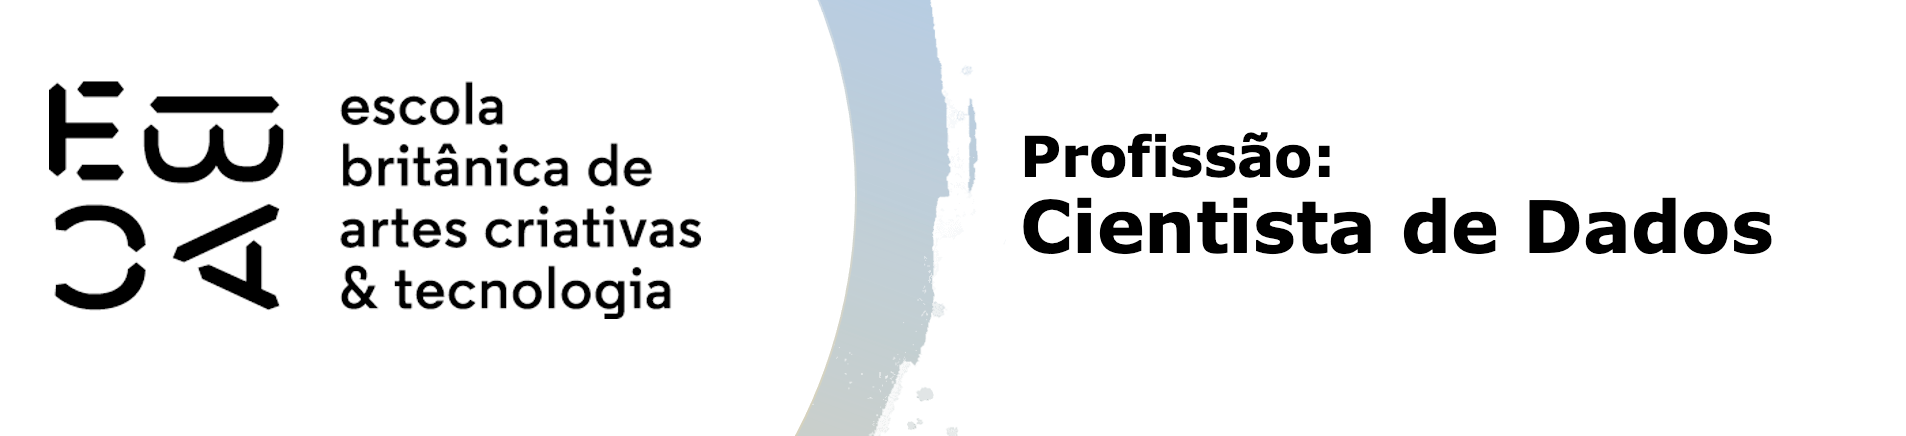

---

<!-- # **Profissão: Cientista de Dados** -->
### **Módulo 38** | Streamlit VI e Pycaret | Exercício I

**Aluno:** [Marcio da Silva](https://www.linkedin.com/in/marcio-d-silva/)<br>
**Data:** 01 de Fevereiro de 2025.

---


# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [6]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Importação das bibliotecas necessárias

# Bibliotecas padrão
import warnings

# Bibliotecas para manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem estatística
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ferramentas do Scikit-learn e SciPy
from sklearn import metrics
from scipy.stats import ks_2samp, t

# Função para cálculo de VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Ignorar warnings específicos (uso com cautela)
warnings.filterwarnings("ignore")


In [8]:
# Carregar o arquivo Feather e exibir as primeiras linhas
df = pd.read_feather('credit_scoring.ftr')
df.head()


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [9]:
# Garantir que a coluna 'data_ref' seja do tipo datetime
df['data_ref'] = pd.to_datetime(df['data_ref'], errors='coerce')

# Obter as datas mínima e máxima
data_minima = df['data_ref'].min()
data_maxima = df['data_ref'].max()

# Exibir os resultados
print(f"A data mínima é: {data_minima}")
print(f"A data máxima é: {data_maxima}")


A data mínima é: 2015-01-01 00:00:00
A data máxima é: 2016-03-01 00:00:00


In [10]:
# Definindo a quantidade de meses e a data inicial
meses = 3
data_inicial = '1/1/2016'

# Criando uma Série com os últimos 'meses' meses a partir de 'data_inicial'
data = pd.Series(pd.date_range(start=data_inicial, periods=meses, freq='MS'))

# Criando o DataFrame
date = pd.DataFrame(data, columns=['oot'])

# Exibindo o DataFrame
date


,oot
0,2016-01-01
1,2016-02-01
2,2016-03-01


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [11]:
# Exibir o número de linhas do DataFrame
print(f'Número de linhas: {df.shape[0]}')

# Garantir que a coluna 'data_ref' seja do tipo datetime e exibir a contagem de valores
df['data_ref'] = pd.to_datetime(df['data_ref'], errors='coerce')
print("\nContagem de valores de 'data_ref':")
df['data_ref'].value_counts()


Número de linhas: 750000

Contagem de valores de 'data_ref':


data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [12]:
# Exibir informações resumidas sobre o DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

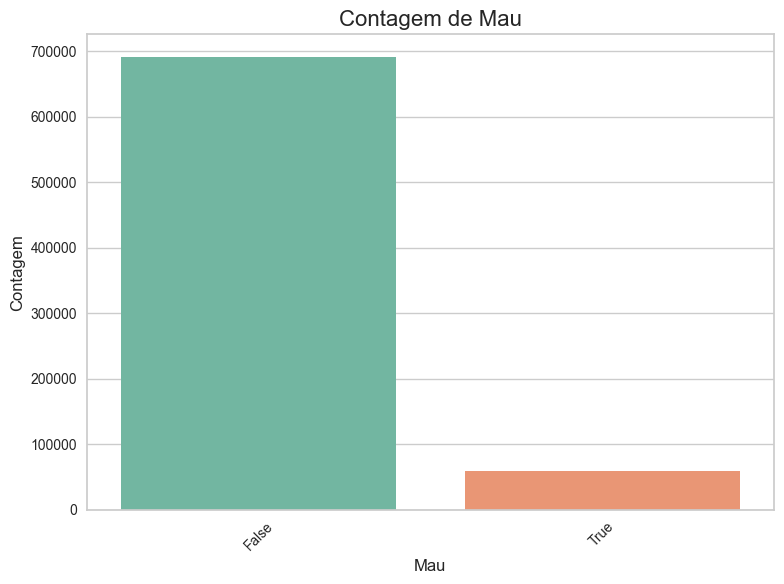

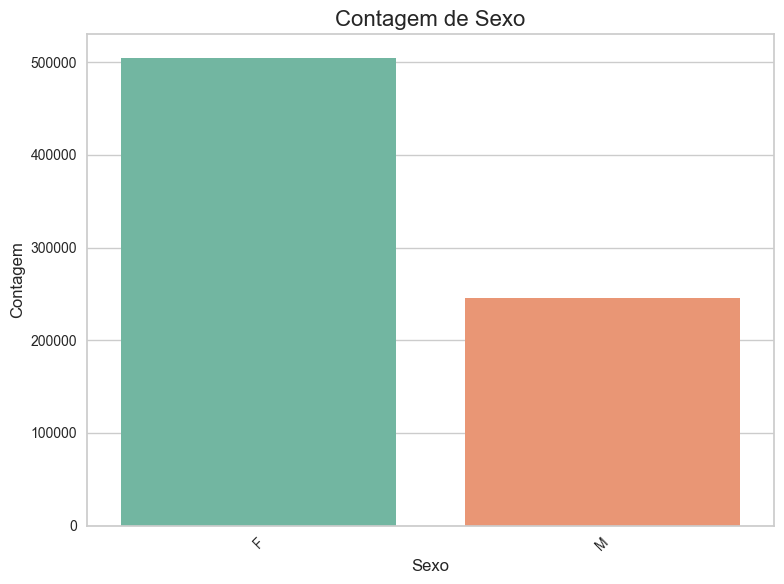

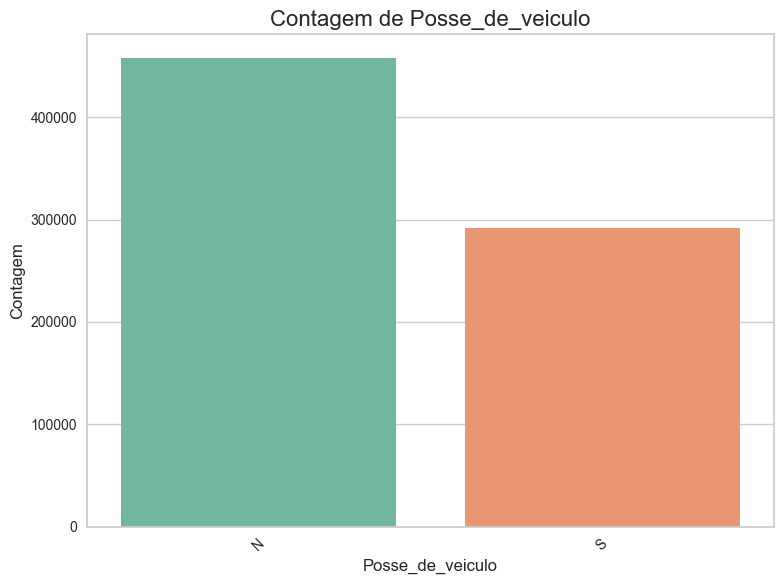

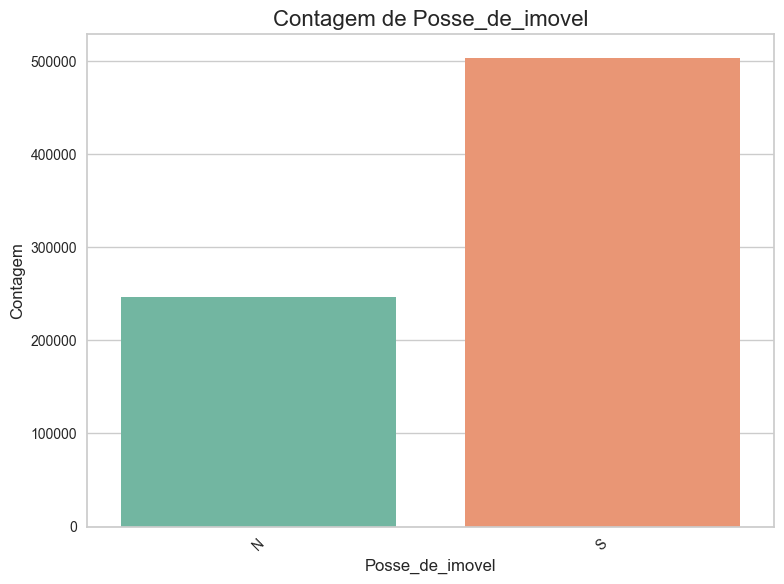

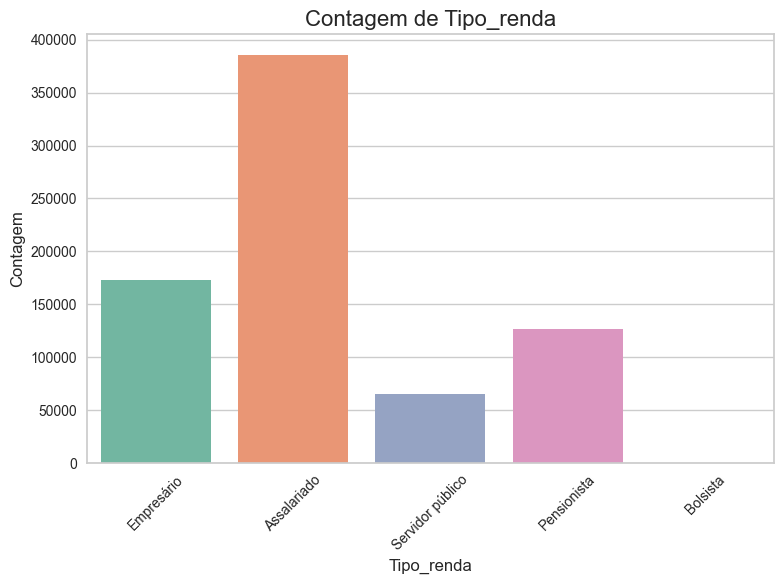

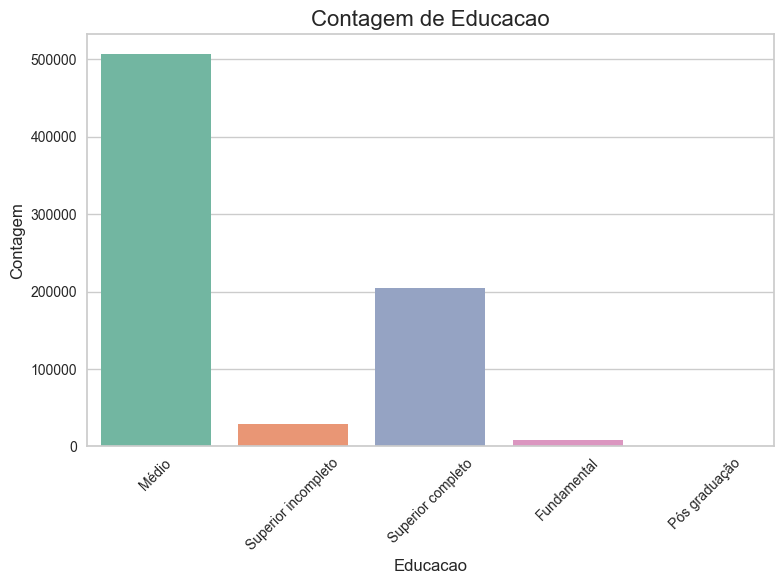

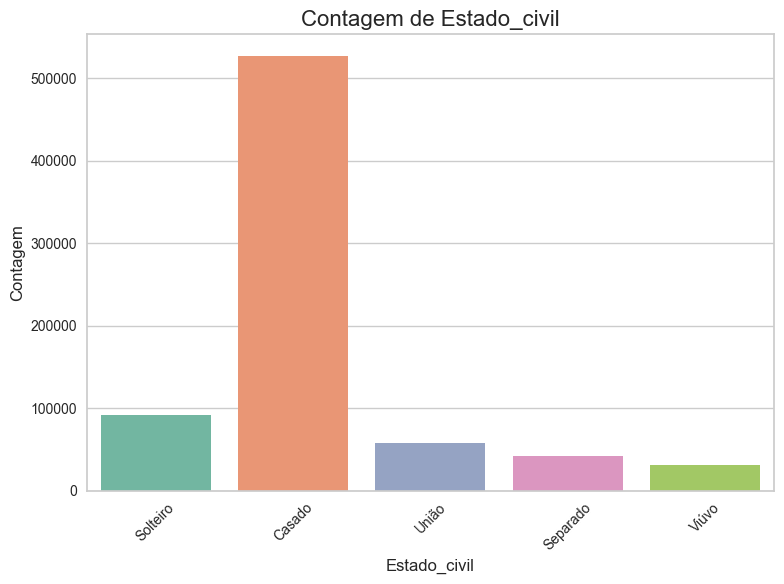

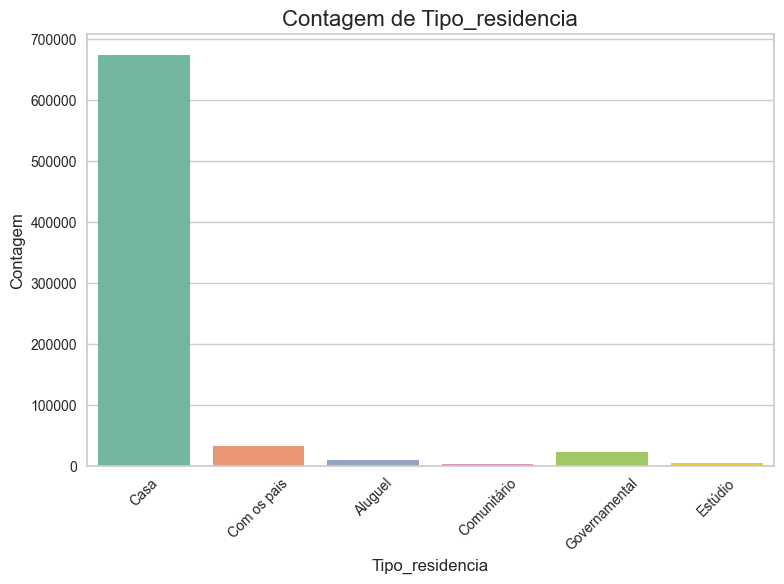

In [13]:
# Lista de variáveis categóricas para as quais vou criar gráficos de barras
variaveis_categoricas = ['mau', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                         'educacao', 'estado_civil', 'tipo_residencia']

# Criar um gráfico de barras para cada variável categórica na lista
for var in variaveis_categoricas:
    plt.figure(figsize=(8, 6))  # Tamanho do gráfico
    sns.countplot(data=df, x=var, palette='Set2')  # Gráfico de barras usando countplot
    plt.title(f'Contagem de {var.capitalize()}', fontsize=16)  # Título com o nome da variável
    plt.xlabel(var.capitalize(), fontsize=12)  # Rótulo do eixo X
    plt.ylabel('Contagem', fontsize=12)  # Rótulo do eixo Y
    plt.xticks(rotation=45)  # Rotacionar rótulos do eixo X, caso necessário
    plt.tight_layout()  # Ajusta o layout para não cortar elementos
    plt.show()  # Exibe o gráfico

<Figure size 800x550 with 0 Axes>

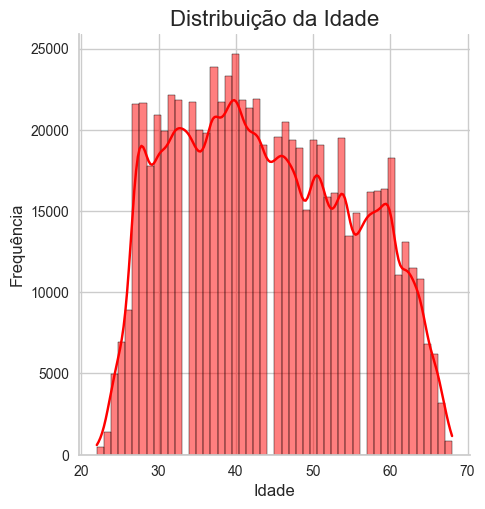

In [14]:
# Limpar qualquer gráfico anterior
plt.clf()

# Definir a variável
var = "idade"

# Criar o gráfico de distribuição com ajustes estéticos
sns.displot(df, x=var, bins=50, color='red', kde=True)

# Adicionar título e rótulos aos eixos
plt.title(f'Distribuição da Idade', fontsize=16)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Exibir o gráfico
plt.show()

<Figure size 800x550 with 0 Axes>

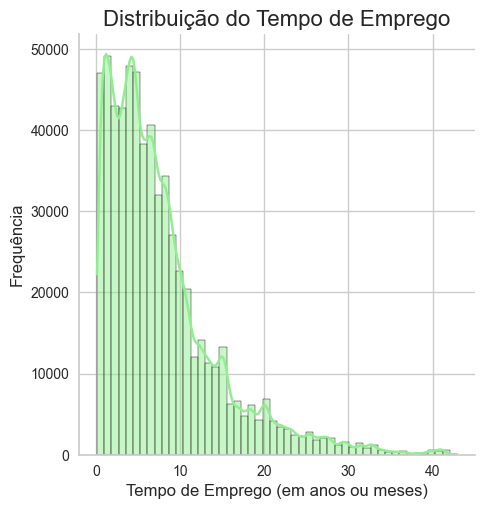

In [15]:
# Limpar qualquer gráfico anterior
plt.clf()

# Definir a variável
var = "tempo_emprego"

# Criar o gráfico de distribuição com ajustes estéticos
sns.displot(df, x=var, bins=50, color='lightgreen', kde=True)

# Adicionar título e rótulos aos eixos
plt.title(f'Distribuição do Tempo de Emprego', fontsize=16)
plt.xlabel('Tempo de Emprego (em anos ou meses)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Exibir o gráfico
plt.show()

<Figure size 800x550 with 0 Axes>

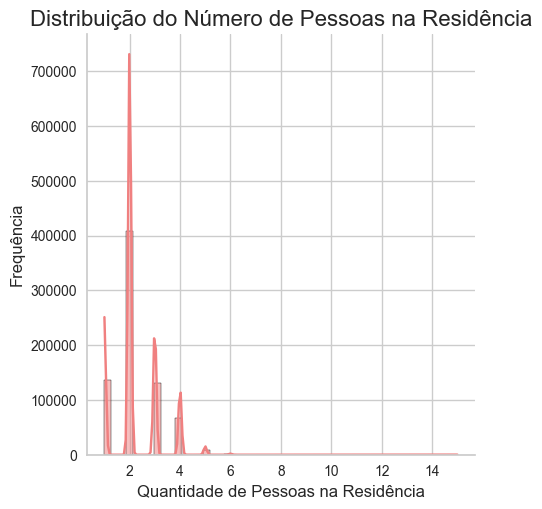

In [16]:
# Limpar qualquer gráfico anterior
plt.clf()

# Definir a variável
var = "qt_pessoas_residencia"

# Criar o gráfico de distribuição com ajustes estéticos
sns.displot(df, x=var, bins=50, color='lightcoral', kde=True)

# Adicionar título e rótulos aos eixos
plt.title(f'Distribuição do Número de Pessoas na Residência', fontsize=16)
plt.xlabel('Quantidade de Pessoas na Residência', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Exibir o gráfico
plt.show()

<Figure size 800x550 with 0 Axes>

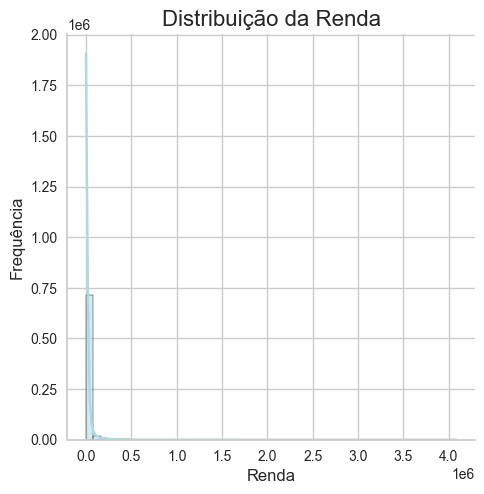

In [17]:
# Limpar qualquer gráfico anterior
plt.clf()

# Definir a variável
var = "renda"

# Criar o gráfico de distribuição com ajustes estéticos
sns.displot(df, x=var, bins=50, color='lightblue', kde=True)

# Adicionar título e rótulos aos eixos
plt.title(f'Distribuição da Renda', fontsize=16)
plt.xlabel('Renda', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Exibir o gráfico
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [18]:
# Exibir informações resumidas sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

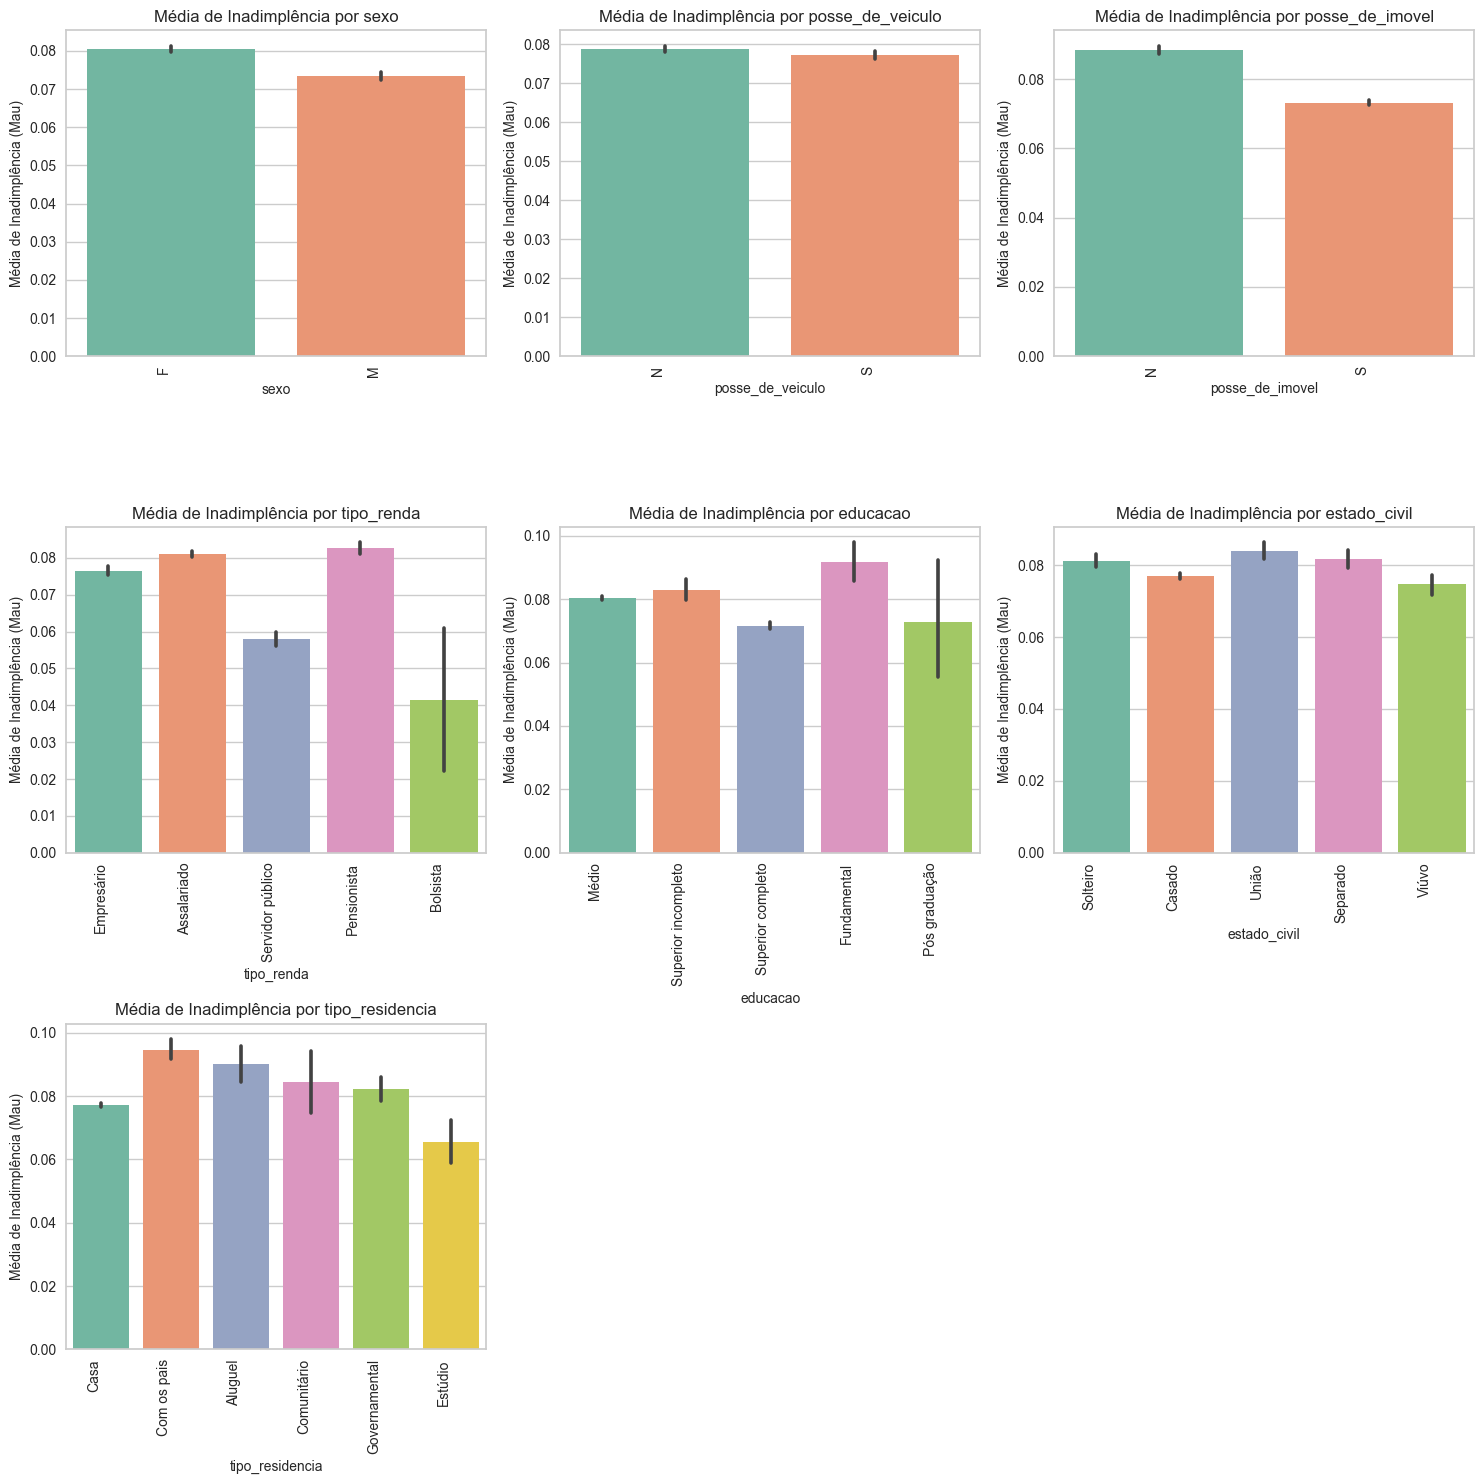

In [19]:
# Definindo as variáveis a serem plotadas
variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
             'educacao', 'estado_civil', 'tipo_residencia']

# Definir o número de linhas e colunas para o grid de subgráficos
n_colunas = 3
n_linhas = (len(variaveis) + n_colunas - 1) // n_colunas  # Calcula o número de linhas para o grid

# Configuração do tamanho do gráfico
plt.figure(figsize=(15, 5 * n_linhas))

# Gerando o gráfico de barras para cada variável
for i, var in enumerate(variaveis, 1):
    plt.subplot(n_linhas, n_colunas, i)  # Define a posição do gráfico
    sns.barplot(x=var, y='mau', data=df, palette='Set2')
    
    # Rotacionar rótulos do eixo X se necessário
    plt.xticks(rotation=90, ha='right')
    
    # Adicionar título e rótulos aos eixos
    plt.title(f'Média de Inadimplência por {var}', fontsize=12)
    plt.xlabel(var, fontsize=10)
    plt.ylabel('Média de Inadimplência (Mau)', fontsize=10)

# Ajustar o layout
plt.tight_layout()

# Exibir os gráficos
plt.show()

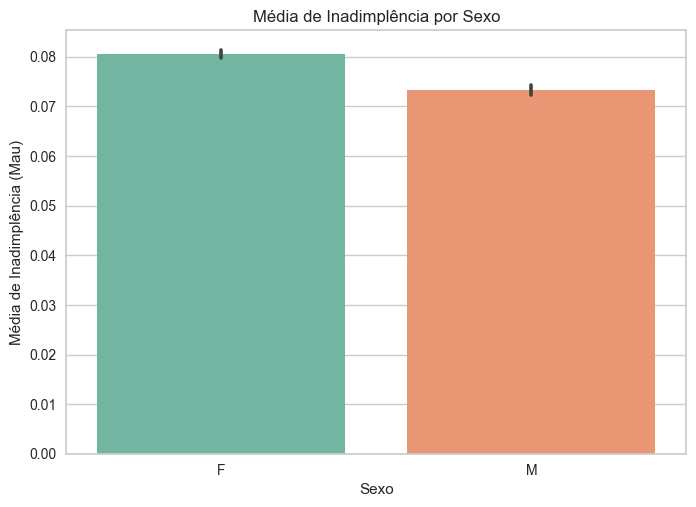

In [20]:
# Gráfico de barras
sns.barplot(x='sexo', y='mau', data=df, palette='Set2')

# Adicionando título e rótulos aos eixos
plt.title('Média de Inadimplência por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Média de Inadimplência (Mau)')

# Exibir o gráfico
plt.show()


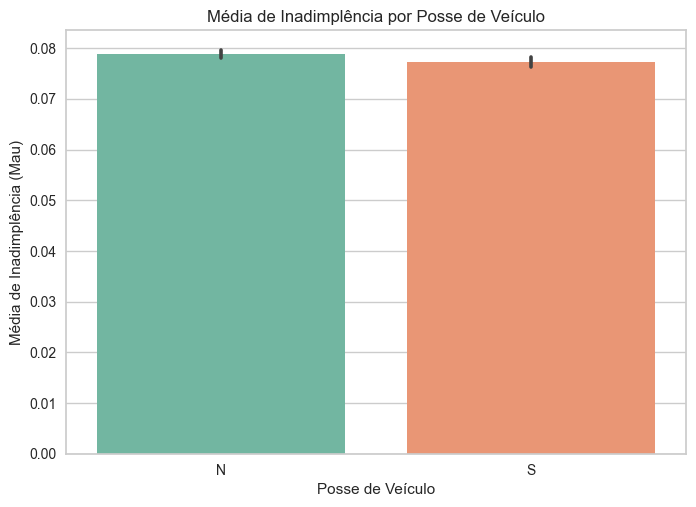

In [21]:
# Criar o gráfico de barras
sns.barplot(x='posse_de_veiculo', y='mau', data=df, palette='Set2')

# Adicionar título e rótulos aos eixos
plt.title('Média de Inadimplência por Posse de Veículo')
plt.xlabel('Posse de Veículo')
plt.ylabel('Média de Inadimplência (Mau)')

# Exibir o gráfico
plt.show()

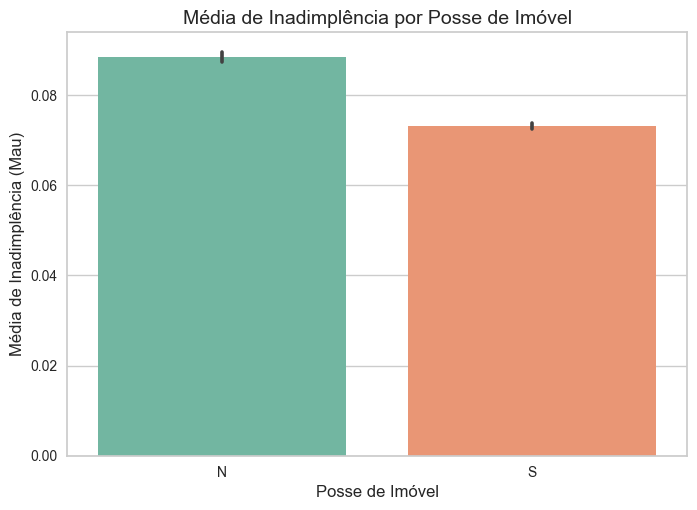

In [22]:
# Criar o gráfico de barras
sns.barplot(x='posse_de_imovel', y='mau', data=df, palette='Set2')

# Adicionar título e rótulos aos eixos
plt.title('Média de Inadimplência por Posse de Imóvel', fontsize=14)
plt.xlabel('Posse de Imóvel', fontsize=12)
plt.ylabel('Média de Inadimplência (Mau)', fontsize=12)

# Exibir o gráfico
plt.show()

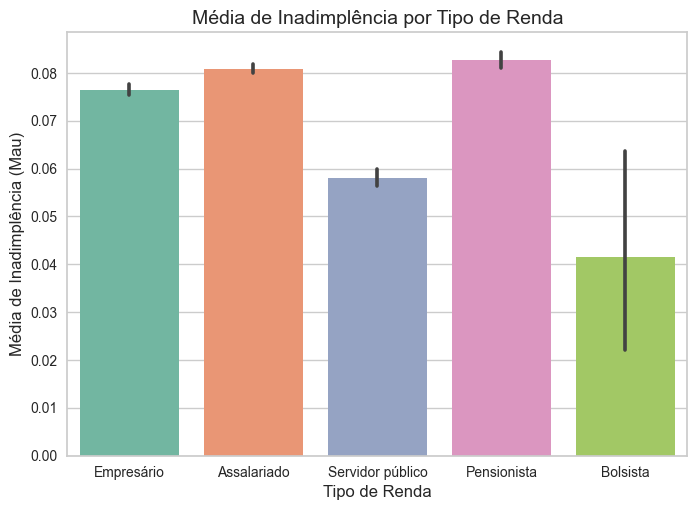

In [23]:
# Criar o gráfico de barras
sns.barplot(x='tipo_renda', y='mau', data=df, palette='Set2')

# Adicionar título e rótulos aos eixos
plt.title('Média de Inadimplência por Tipo de Renda', fontsize=14)
plt.xlabel('Tipo de Renda', fontsize=12)
plt.ylabel('Média de Inadimplência (Mau)', fontsize=12)

# Exibir o gráfico
plt.show()

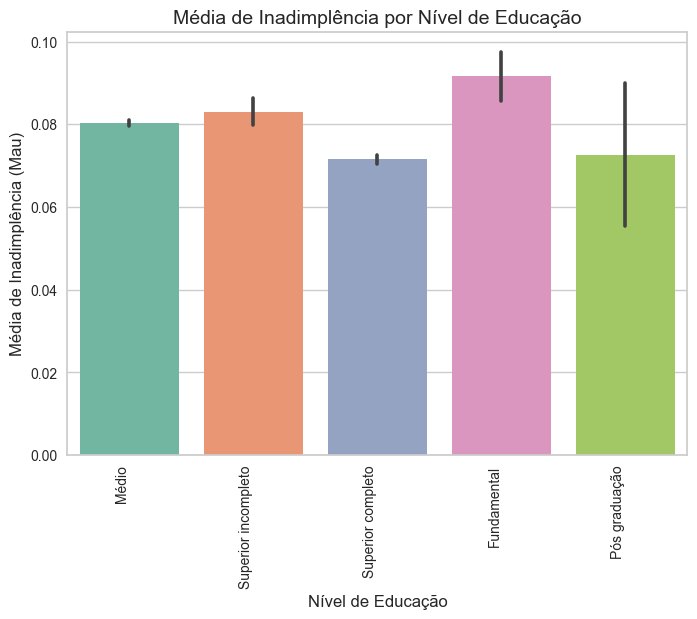

In [24]:
# Criar o gráfico de barras
educacao = sns.barplot(x='educacao', y='mau', data=df, palette='Set2')

# Rotacionar os rótulos do eixo X (educacao) para 90 graus
educacao.set_xticklabels(educacao.get_xticklabels(), rotation=90, horizontalalignment='right')

# Adicionar título e rótulos aos eixos
plt.title('Média de Inadimplência por Nível de Educação', fontsize=14)
plt.xlabel('Nível de Educação', fontsize=12)
plt.ylabel('Média de Inadimplência (Mau)', fontsize=12)

# Exibir o gráfico
plt.show()

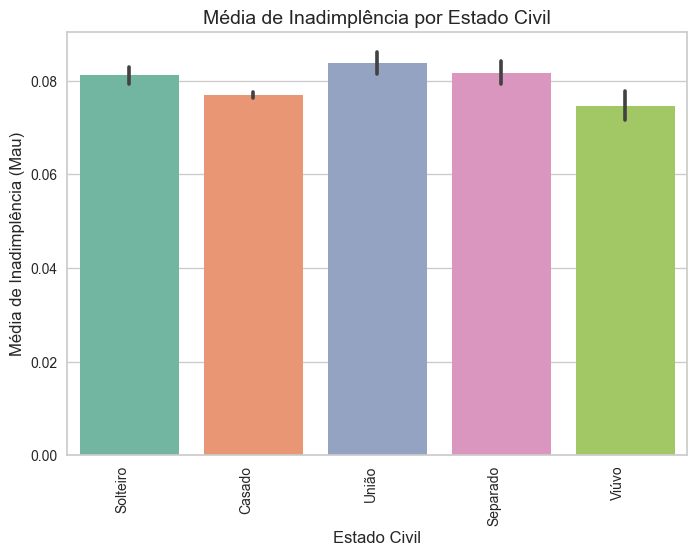

In [25]:
# Criar o gráfico de barras
estado_civil = sns.barplot(x='estado_civil', y='mau', data=df, palette='Set2')

# Rotacionar os rótulos do eixo X (estado_civil) para 90 graus, se necessário
estado_civil.set_xticklabels(estado_civil.get_xticklabels(), rotation=90, horizontalalignment='right')

# Adicionar título e rótulos aos eixos
plt.title('Média de Inadimplência por Estado Civil', fontsize=14)
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Média de Inadimplência (Mau)', fontsize=12)

# Exibir o gráfico
plt.show()

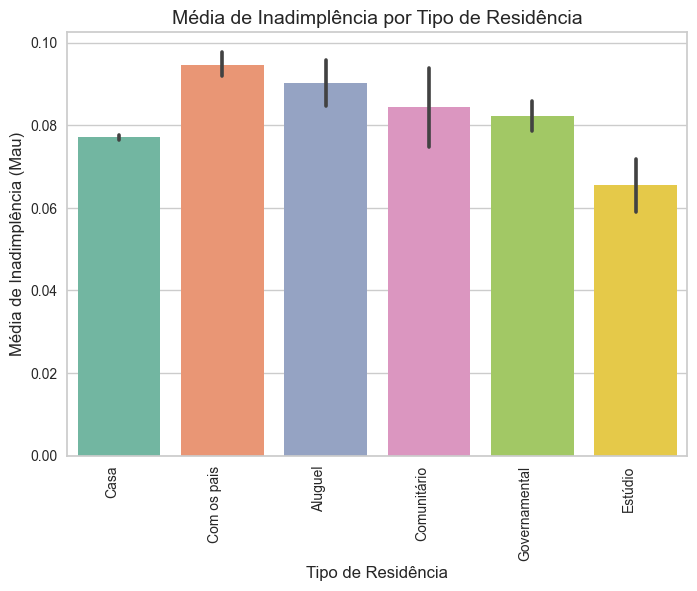

In [26]:
# Criar o gráfico de barras
tipo_residencia = sns.barplot(x='tipo_residencia', y='mau', data=df, palette='Set2')

# Rotacionar os rótulos do eixo X (tipo_residencia) para 90 graus
tipo_residencia.set_xticklabels(tipo_residencia.get_xticklabels(), rotation=90, horizontalalignment='right')

# Adicionar título e rótulos aos eixos
plt.title('Média de Inadimplência por Tipo de Residência', fontsize=14)
plt.xlabel('Tipo de Residência', fontsize=12)
plt.ylabel('Média de Inadimplência (Mau)', fontsize=12)

# Exibir o gráfico
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [27]:
# Verificando a quantidade de valores nulos em cada coluna do DataFrame
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [28]:
df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

0          6.873973
1          4.526027
2          0.243836
3         12.772603
4          8.432877
            ...    
749995     3.038356
749996     7.748574
749997    10.375342
749998    13.780822
749999    10.375342
Name: tempo_emprego, Length: 750000, dtype: float64

In [29]:
metadados = pd.concat([df.dtypes, df.nunique()], axis=1, keys=['dtype', 'valores_unicos'])
metadados

,dtype,valores_unicos
data_ref,datetime64[ns],15
index,int64,16650
sexo,object,2
posse_de_veiculo,object,2
posse_de_imovel,object,2
qtd_filhos,int64,8
tipo_renda,object,5
educacao,object,5
estado_civil,object,5
tipo_residencia,object,6


In [30]:
df['mau'] = df.mau.astype('int64')

In [31]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [32]:
iv_sexo = IV(df.sexo, df.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.2%


In [33]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['valores_unicos'] = df.nunique()
metadados['variavel'] = 'covariavel'

# Verificando se os índices 'mau' e 'bom' existem antes de atribuir
metadados.loc[metadados.index.isin(['mau', 'bom']), 'variavel'] = 'resposta'

metadados

,dtype,valores_unicos,variavel
data_ref,datetime64[ns],15,covariavel
index,int64,16650,covariavel
sexo,object,2,covariavel
posse_de_veiculo,object,2,covariavel
posse_de_imovel,object,2,covariavel
qtd_filhos,int64,8,covariavel
tipo_renda,object,5,covariavel
educacao,object,5,covariavel
estado_civil,object,5,covariavel
tipo_residencia,object,6,covariavel


In [34]:
var='idade'
IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)

0.01796842289500074

In [35]:
for var in metadados[metadados.variavel == 'covariavel'].index:
    valores_unicos = metadados.loc[var, 'valores_unicos']
    
    if valores_unicos > 6:
        # Usando qcut para dividir em 5 quantis
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
    else:
        # Se a variável tiver menos ou igual a 6 valores únicos, calcular o IV diretamente
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)
        
metadados

,dtype,valores_unicos,variavel,IV
data_ref,datetime64[ns],15,covariavel,0.345982
index,int64,16650,covariavel,0.002664
sexo,object,2,covariavel,0.002185
posse_de_veiculo,object,2,covariavel,0.000108
posse_de_imovel,object,2,covariavel,0.009693
qtd_filhos,int64,8,covariavel,0.000030
tipo_renda,object,5,covariavel,0.009360
educacao,object,5,covariavel,0.003547
estado_civil,object,5,covariavel,0.001126
tipo_residencia,object,6,covariavel,0.003045


In [36]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)
    
    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                       'qt_mau': g['bom'].sum(),
                       'mau':g['bom'].mean(),
                       var: g['bom'].mean().index,
                       'cont':g[var].count()})
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_sup/(1-biv.mau_inf))
    
    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))
    
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe,  ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite superior')
        
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])
    
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

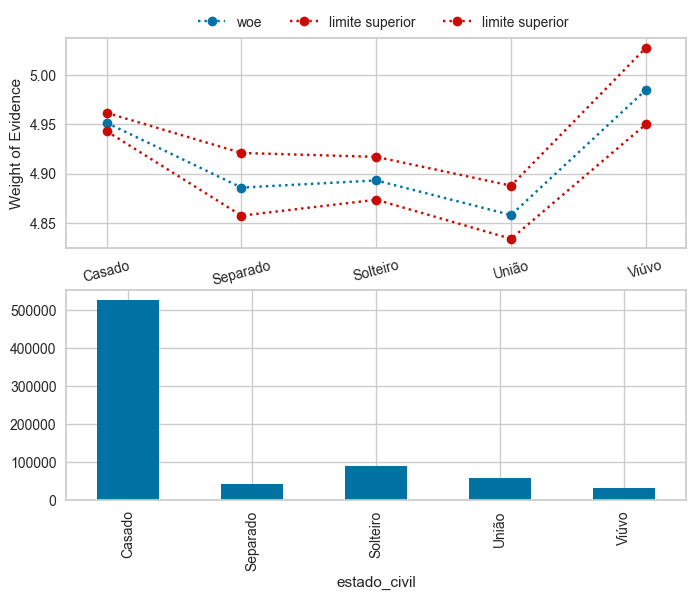

In [37]:
biv_discreta('estado_civil', df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,354527,0.919083,Assalariado,385740,0.000439,0.919943,0.918222,2.429950,2.441578,2.420306,4.897138,4.908766,4.887495
Bols./SerPubl,61497,61497,0.942006,Bols./SerPubl,65283,0.000915,0.943799,0.940213,2.787678,2.820985,2.759132,5.254866,5.288173,5.226320
Empresário,159508,159508,0.923549,Empresário,172712,0.000639,0.924802,0.922296,2.491574,2.509458,2.476671,4.958762,4.976646,4.943859
Pensionista,115825,115825,0.917317,Pensionista,126265,0.000775,0.918836,0.915798,2.406436,2.426634,2.389885,4.873624,4.893822,4.857073


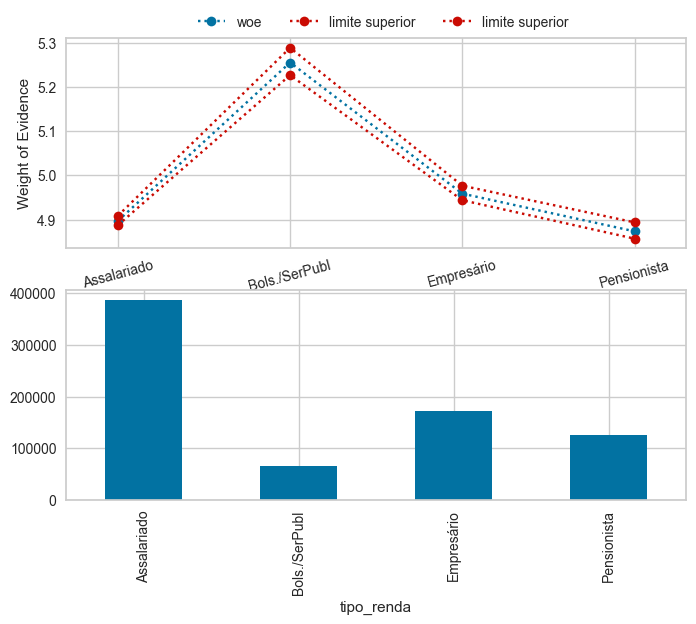

In [38]:
df2 = df.copy()
df2.tipo_renda.replace({'Bolsista': 'Bols./SerPubl', 'Servidor público': 'Bols./SerPubl'}, inplace=True)
biv_discreta('tipo_renda', df2)

In [39]:
IV(df2.tipo_renda, df.mau)

0.009314630323182816

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,7789,7789,0.908338,Fundamental,8575,0.003116,0.914446,0.902230,2.293511,2.369175,2.235701,4.760699,4.836363,4.702889
Médio,466106,466106,0.919639,Médio,506836,0.000382,0.920387,0.918890,2.437448,2.447619,2.428992,4.904636,4.914807,4.896180
Sup.Compl/PosGra,190437,190437,0.928427,Sup.Compl/PosGra,205118,0.000569,0.929542,0.927311,2.562767,2.579677,2.548502,5.029955,5.046865,5.015690
Superior incompleto,27025,27025,0.917003,Superior incompleto,29471,0.001607,0.920153,0.913853,2.402308,2.444427,2.368489,4.869496,4.911615,4.835677


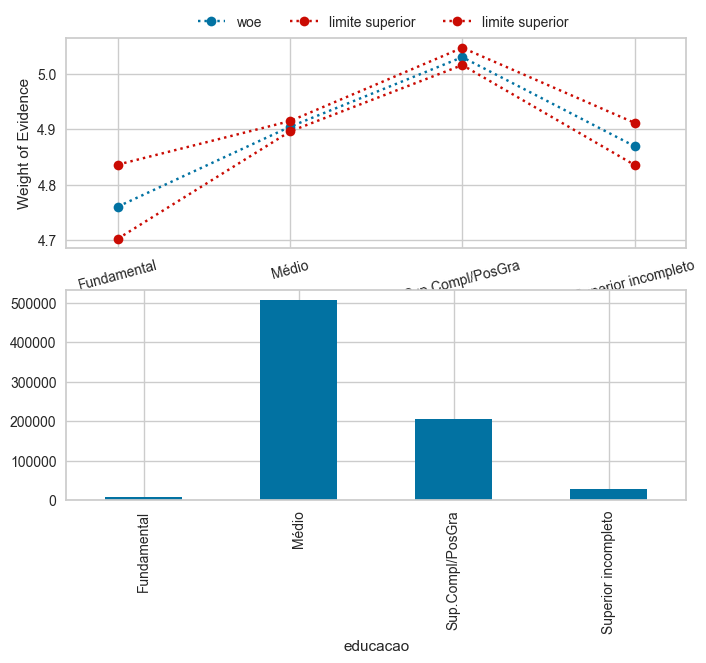

In [40]:
# Mapeamento de valores da coluna 'educacao' para uma versão mais abreviada
mapeamento_educacao = {
    'Superior completo': 'Sup.Compl/PosGra', 
    'Pós graduação': 'Sup.Compl/PosGra'
}

# Substituindo os valores da coluna 'educacao' usando o map
df2['educacao'] = df2['educacao'].map(mapeamento_educacao).fillna(df2['educacao'])

# Gerando o gráfico/distribuição
biv_discreta('educacao', df2)


0.0023941390471014087

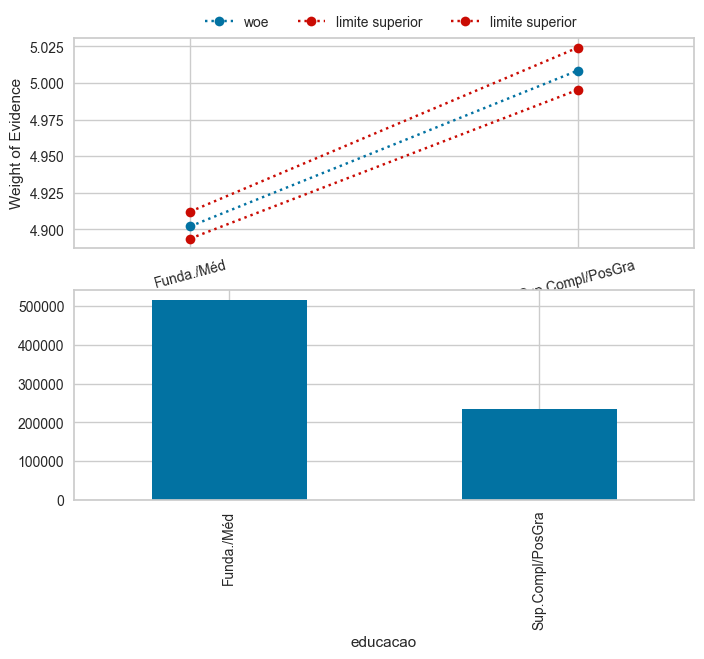

In [41]:
# Mapeamento de valores para uma versão mais curta/abreviada
df2['educacao'].replace({
    'Superior incompleto': 'Sup.Compl/PosGra', 
    'Fundamental': 'Funda./Méd',
    'Médio': 'Funda./Méd'
}, inplace=True)

# Gerar gráfico de distribuição para a coluna 'educacao'
biv_discreta('educacao', df2)

# Calcular e mostrar o índice de variabilidade (IV) para a coluna 'educacao'
IV(df2['educacao'], df.mau)


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e out of time.

In [42]:
# Exemplo de DataFrames (substitua com seus próprios dados)
df = pd.DataFrame({
    'mau': [1, 0, 1, 0, 1],
})
date = pd.DataFrame({
    'oot': ['2023-01-01', '2023-01-02', '2023-01-01', '2023-01-03', '2023-01-01'],
})

# Criando a tabela cruzada
tabela_crosstab = pd.crosstab(df['mau'], date['oot'])

# Exibindo a tabela cruzada
tabela_crosstab


oot,2023-01-01,2023-01-02,2023-01-03
mau,,,
0,0,1,1
1,3,0,0


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [43]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

pca = PCA(n_components=20)

scaler = StandardScaler()

logistic = LogisticRegression(max_iter=200)

In [44]:
X_digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [45]:
X_digits.shape

(1797, 64)

## Dataset de treino

In [46]:
# "Fitando" e aplicando Z score nos dados de treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [47]:
# "Fitando" e aplicando o pca nos dados de treino
pca.fit(X_train)
X_train = pca.transform(X_train)

In [48]:
# "Fitando" e predizendo uma regressão logística nos dados de treino
logistic.fit(X_train, y_train)

logistic.predict(X_train)

array([0, 0, 0, ..., 2, 1, 2])

## Dataset de teste

In [49]:
# Aplicando nos dados de teste o Z score "fitado" nos dados de treino  
X_test = scaler.transform(X_test)

In [50]:
# Aplicando nos dados de teste o PCA "fitado" nos dados de treino  
X_test = pca.transform(X_test)

In [51]:
# Predizendo nos dados de teste o modelo "fitado" nos dados de treino
logistic.predict(X_test)

array([5, 2, 5, 4, 8, 3, 4, 3, 3, 0, 8, 7, 0, 1, 8, 6, 9, 7, 9, 7, 1, 6,
       6, 7, 8, 8, 5, 8, 9, 9, 3, 3, 7, 3, 4, 1, 9, 2, 5, 4, 2, 1, 0, 1,
       2, 9, 6, 1, 9, 4, 4, 5, 8, 4, 8, 5, 9, 7, 8, 0, 4, 5, 8, 4, 7, 9,
       0, 7, 1, 3, 9, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 8,
       8, 8, 2, 6, 3, 4, 7, 9, 8, 2, 9, 2, 5, 0, 8, 0, 4, 8, 8, 0, 6, 7,
       3, 3, 9, 1, 2, 4, 6, 0, 8, 8, 1, 1, 7, 3, 9, 5, 2, 3, 3, 9, 7, 6,
       2, 5, 4, 3, 8, 7, 6, 7, 2, 7, 4, 9, 5, 1, 9, 8, 6, 1, 8, 1, 4, 0,
       9, 9, 1, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 8, 6, 7, 0,
       9, 9, 4, 7, 5, 5, 2, 0, 6, 7, 5, 3, 9, 7, 1, 3, 2, 8, 3, 3, 1, 7,
       1, 1, 1, 7, 1, 6, 7, 6, 9, 5, 2, 3, 5, 2, 9, 5, 4, 8, 2, 9, 1, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 9, 0, 6, 9,
       4, 4, 9, 7, 5, 6, 1, 5, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 9, 7, 2, 0, 2, 0, 9, 2, 8, 6, 3, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 2, 0, 8, 4, 7, 3, 3,

## Usando pipeline

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=15)

# Define a Standard Scaler to normalize inputs
scaler_pipe = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic_pipe = LogisticRegression(max_iter=200)

In [53]:
pipe = Pipeline(steps=[("scaler", scaler_pipe), 
                       ("pca", pca_pipe), 
                       ("logistic", logistic_pipe)])

In [54]:
pipe.named_steps

{'scaler': StandardScaler(),
 'pca': PCA(n_components=15),
 'logistic': LogisticRegression(max_iter=200)}

## Dados do treino

In [55]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('logistic', LogisticRegression(max_iter=200))])

In [56]:
pipe.predict(X_train)

array([0, 0, 0, ..., 1, 8, 2])

## Dados de teste

In [57]:
pipe.predict(X_test)

array([5, 2, 5, 4, 8, 1, 4, 3, 3, 0, 8, 7, 0, 1, 8, 6, 9, 7, 9, 7, 1, 6,
       6, 7, 8, 8, 5, 8, 9, 9, 3, 3, 7, 3, 4, 1, 9, 2, 5, 4, 2, 1, 0, 1,
       2, 3, 6, 1, 9, 4, 4, 9, 8, 4, 8, 5, 9, 7, 1, 0, 4, 5, 8, 4, 7, 9,
       0, 7, 1, 3, 3, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 8,
       8, 8, 2, 6, 3, 4, 7, 9, 8, 2, 9, 2, 5, 0, 8, 0, 4, 8, 8, 0, 6, 7,
       3, 3, 9, 1, 2, 4, 6, 0, 8, 8, 1, 1, 7, 8, 9, 5, 2, 3, 3, 9, 7, 6,
       2, 5, 4, 3, 8, 4, 6, 7, 2, 7, 4, 9, 5, 1, 9, 8, 6, 1, 8, 1, 4, 0,
       9, 9, 1, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 8, 6, 7, 0,
       9, 9, 4, 7, 9, 5, 2, 0, 6, 7, 5, 3, 9, 7, 1, 3, 2, 8, 8, 3, 1, 7,
       1, 1, 1, 7, 1, 6, 7, 6, 9, 5, 2, 3, 5, 2, 9, 5, 4, 8, 2, 0, 1, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 9, 0, 6, 9,
       4, 4, 9, 7, 5, 6, 1, 8, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 9, 7, 2, 0, 2, 0, 9, 2, 8, 6, 3, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 2, 0, 8, 4, 7, 3, 3,

## Analisando o objeto

In [58]:
pipe.named_steps

{'scaler': StandardScaler(),
 'pca': PCA(n_components=15),
 'logistic': LogisticRegression(max_iter=200)}

In [59]:
pipe.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=15)),
 ('logistic', LogisticRegression(max_iter=200))]

In [60]:
pipe[0]

StandardScaler()

In [61]:
pipe[1]

PCA(n_components=15)

In [62]:
pipe[2]

LogisticRegression(max_iter=200)

In [63]:
pipe[1].transform(X_train)

array([[  0.87097879, -12.61627492, -18.9562725 , ...,   5.34353979,
         16.00891379,   3.84740808],
       [  7.39000546,  -7.84634212, -16.49072302, ...,   8.70612702,
         19.90808919,   2.77276875],
       [  8.28997682, -10.02874543, -14.17162408, ...,   9.26167441,
         27.37471621,   4.1293817 ],
       ...,
       [-12.90640544, -12.77047949,  16.69152215, ...,   1.63512952,
         10.5661053 ,   6.63094251],
       [-12.20199325,  -2.58791666,   7.00747296, ...,   8.57498314,
         10.18475805,   2.91119489],
       [-11.21463487,   2.61276368,   2.68275181, ...,   4.13738932,
         18.82315766,  -4.74542031]])

In [64]:
pca_pipe.transform(X_train)

array([[  0.87097879, -12.61627492, -18.9562725 , ...,   5.34353979,
         16.00891379,   3.84740808],
       [  7.39000546,  -7.84634212, -16.49072302, ...,   8.70612702,
         19.90808919,   2.77276875],
       [  8.28997682, -10.02874543, -14.17162408, ...,   9.26167441,
         27.37471621,   4.1293817 ],
       ...,
       [-12.90640544, -12.77047949,  16.69152215, ...,   1.63512952,
         10.5661053 ,   6.63094251],
       [-12.20199325,  -2.58791666,   7.00747296, ...,   8.57498314,
         10.18475805,   2.91119489],
       [-11.21463487,   2.61276368,   2.68275181, ...,   4.13738932,
         18.82315766,  -4.74542031]])

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.



In [66]:
dummy = pd.get_dummies(df2, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])
dummy

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom,sexo_F,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,5733,0,43,6.873973,1.0,2515.39,0,1,True,...,False,True,False,False,False,True,False,False,False,False
1,2015-01-01,727,0,35,4.526027,2.0,3180.19,0,1,True,...,False,False,False,False,False,True,False,False,False,False
2,2015-01-01,6374,2,31,0.243836,4.0,1582.29,0,1,True,...,False,False,False,False,False,True,False,False,False,False
3,2015-01-01,9566,0,54,12.772603,2.0,13721.17,0,1,True,...,False,False,False,False,False,True,False,False,False,False
4,2015-01-01,9502,0,31,8.432877,1.0,2891.08,0,1,True,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,0,48,3.038356,2.0,2109.99,0,1,False,...,False,False,False,False,False,True,False,False,False,False
749996,2016-03-01,7000,0,65,NaN,1.0,1389.39,0,1,True,...,False,True,False,False,False,True,False,False,False,False
749997,2016-03-01,14023,2,43,10.375342,4.0,649.06,1,0,False,...,False,False,False,False,False,True,False,False,False,False
749998,2016-03-01,2396,0,56,13.780822,1.0,4216.72,1,0,True,...,False,False,False,True,False,True,False,False,False,False


## Treinar um modelo de regressão logistica com o resultado

In [67]:
dummy.dtypes

data_ref                         datetime64[ns]
index                                     int64
qtd_filhos                                int64
idade                                     int64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                       int64
bom                                       int64
sexo_F                                     bool
sexo_M                                     bool
posse_de_veiculo_N                         bool
posse_de_veiculo_S                         bool
posse_de_imovel_N                          bool
posse_de_imovel_S                          bool
tipo_renda_Assalariado                     bool
tipo_renda_Bols./SerPubl                   bool
tipo_renda_Empresário                      bool
tipo_renda_Pensionista                     bool
educacao_Funda./Méd                        bool
educacao_Sup.Compl/PosGra               

## b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo lightgbm. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.

In [71]:
import pandas as pd

# Carregar o dataset e exibir as primeiras linhas
file_path = 'credit_scoring.ftr'
df = pd.read_feather(file_path)

# Exibir as primeiras linhas do dataframe
df.head()


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [72]:
dataset = df.sample(50000, random_state=42)  # Seleciona 50.000 amostras aleatórias

In [73]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [74]:
dataset = df.sample(40000, random_state=42)  # Seleciona 40.000 amostras aleatórias


In [75]:
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)


In [76]:
# Dividir o dataset em 95% para treino/teste e 5% para validação
data = dataset.sample(frac=0.95, random_state=786)  # Seleciona 95% dos dados
data_unseen = dataset.drop(data.index)  # O restante (5%) é para validação

# Resetar os índices para garantir que sejam sequenciais
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

# Exibir as formas dos dois subconjuntos
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (38000, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2000, 13)


### Alterando dados do treino

In [84]:
from pycaret.classification import *

# Listar os modelos de classificação
models()


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [85]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [97]:
# Forçando a variável qtd_filhos a ser numérica (float)
data.qtd_filhos = data.qtd_filhos.astype(float)


In [101]:
# Exibir a matriz de correlação
corr_matrix

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
qtd_filhos,1.000000,-0.377135,-0.081809,0.888254,-0.044454
idade,-0.377135,1.000000,0.331760,-0.343795,0.095788
tempo_emprego,-0.081809,0.331760,1.000000,-0.072090,0.467333
qt_pessoas_residencia,0.888254,-0.343795,-0.072090,1.000000,-0.048318
renda,-0.044454,0.095788,0.467333,-0.048318,1.000000


In [102]:
data.mau.value_counts(normalize=True)

mau
False    0.919921
True     0.080079
Name: proportion, dtype: float64

In [103]:
exp_aula4 = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method='quantile',
                  fix_imbalance=True)


,Description,Value
0,Session id,3910
1,Target,mau
2,Target type,Binary
3,Original data shape,"(38000, 13)"
4,Transformed data shape,"(60340, 30)"
5,Transformed train set shape,"(48940, 30)"
6,Transformed test set shape,"(11400, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


In [104]:
best_model = compare_models(fold=4, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9183,0.7623,0.0634,0.4342,0.1105,0.0919,0.1416,1.8075
gbc,Gradient Boosting Classifier,0.9177,0.7614,0.0737,0.4223,0.1254,0.1041,0.1500,3.2075
ada,Ada Boost Classifier,0.9103,0.7532,0.1038,0.3337,0.1509,0.1181,0.1435,1.1100
lr,Logistic Regression,0.8969,0.7437,0.2197,0.3023,0.2544,0.2005,0.2035,2.8700
lda,Linear Discriminant Analysis,0.8868,0.7218,0.2329,0.2651,0.2479,0.1870,0.1875,0.2475
ridge,Ridge Classifier,0.8859,0.7216,0.2352,0.2630,0.2481,0.1867,0.1871,0.3575
svm,SVM - Linear Kernel,0.9095,0.7128,0.1239,0.3391,0.1753,0.1392,0.1614,0.3900
rf,Random Forest Classifier,0.8985,0.6885,0.1023,0.2173,0.1391,0.0925,0.1000,1.5175
et,Extra Trees Classifier,0.8835,0.6429,0.1183,0.1718,0.1401,0.0798,0.0814,1.0575
nb,Naive Bayes,0.1024,0.6384,0.9864,0.0810,0.1497,0.0020,0.0198,0.2400


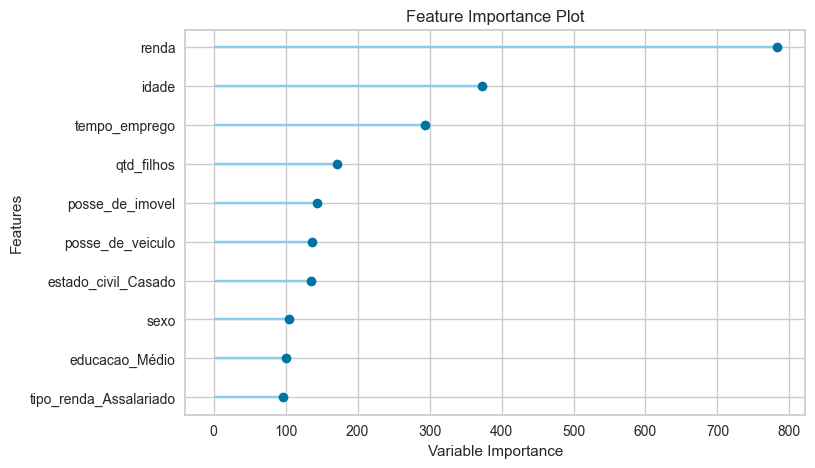

In [105]:
plot_model(best_model, plot='feature')

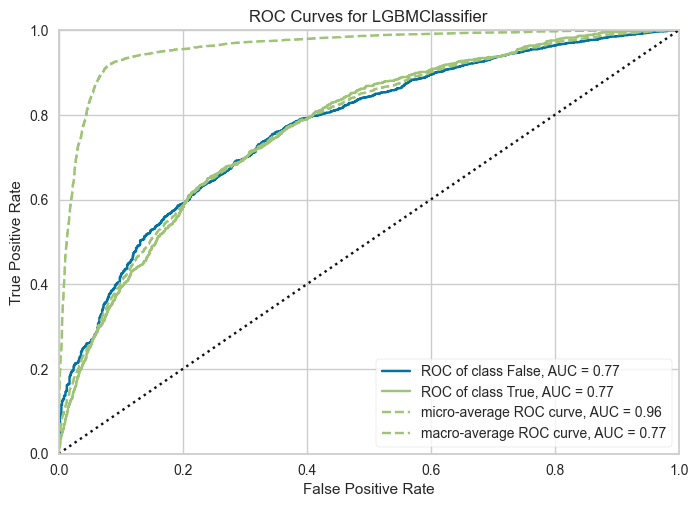

In [106]:
plot_model(best_model, plot='auc')

In [107]:
save_model(best_model,'LR Model Aula 5 062022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

In [108]:
model_saved = load_model('LR Model Aula 5 062022')

Transformation Pipeline and Model Successfully Loaded


In [109]:
model_saved.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,


In [110]:
exp_aula4 = setup(data = dummy, target = 'mau',
                  normalize = True, 
                  transformation = True, 
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  bin_numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'])


,Description,Value
0,Session id,7867
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 32)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Numeric features,7
8,Date features,1
9,Rows with missing values,16.8%


In [112]:
lightgbm = create_model('lightgbm')
tuned_lightgbm = tune_model(lightgbm)
final_lightgbm = finalize_model(tuned_lightgbm)
evaluate_model(final_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

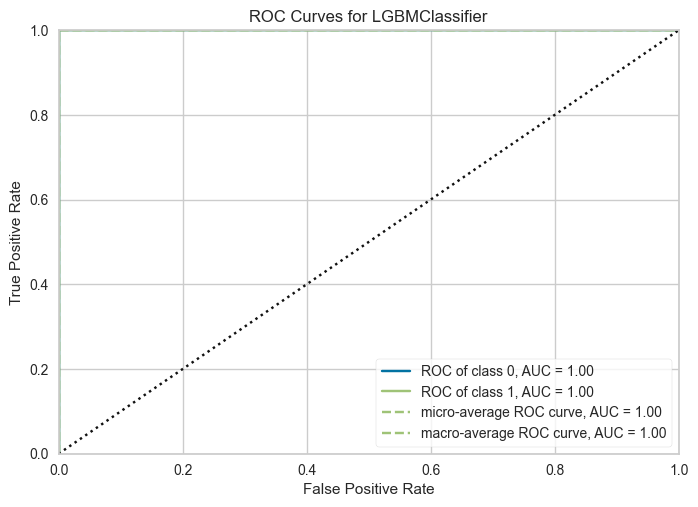

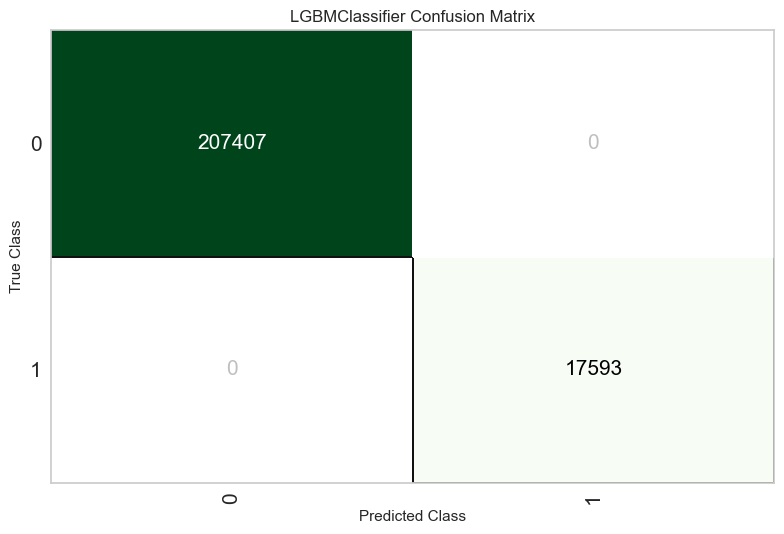

In [ ]:
plot_model(final_lightgbm, plot='auc')
plot_model(final_lightgbm, plot='confusion_matrix')